In [1]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
import rioxarray as rxr
import xarray as xr
import rasterio
from rasterio.plot import show

from osgeo import gdal
import earthpy as et
from shapely.geometry  import box
from tifffile import imsave
import earthpy.plot as ep

# data paths

In [2]:
# raw data paths

nitrogen_path = os.path.join(et.io.HOME, 
                             'desktop', 
                             'earth-analytics', 
                             'python', 
                             'watersheds-biodiversity', 
                             'raw-data', 
                             'nitrogen')

nitrogen_to_mosaic = glob.glob(os.path.join(str(nitrogen_path), "*.tif"))



In [3]:
# crop path


clip_path = os.path.join(et.io.HOME,
                           'desktop',
                           'earth-analytics',
                           'python',
                           'watersheds-biodiversity',
                           'clip-data',
                           'RR_HU8-polygon.shp')


# read file with geopandas 

clip_boundary = gpd.read_file(clip_path)



# functions section

In [6]:

# function for clipping to shp and opening with rioxarray 

def open_clean_bands(band_path,
                     crop_bound,
                     valid_range=None,
                     variable=None):
    # YOUR CODE HERE

    """Open and clean a single landsat band .

    Parameters
    -----------
    band_path:string A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
    A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
     A tuple of min and max range of values for the data. Default = None

    Returns
    -----------
     band : xarray DataArray
        An xarray DataArray clipped to a crop boundary and masked if a range is given
    """

    crop_bound_box = [box(*crop_bound.bounds.loc[0])]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable, 
                                 parse_coordinates=False).rio.clip(crop_bound_box,
                                                             #crs=crop_bound.crs,
                                                             all_touched=True,
                                                             from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band



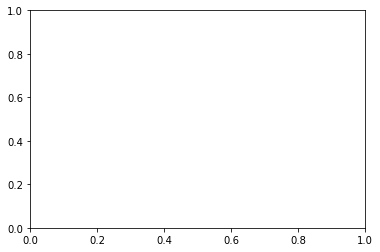

In [15]:
def plot_array(array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

# clipping section

In [7]:
# reproject boundary data

# open one flight path raster
nitrogen_raster = rxr.open_rasterio(nitrogen_to_mosaic[0], parse_coordinates=False)

# extract CRS from raster
nitrogen_crs = nitrogen_raster.rio.crs

# reproject boundary to flight path CRS
clip_boundary_reproj = clip_boundary.to_crs(nitrogen_crs)



In [8]:
# run open_clean_bands() on flight path rasters
# output: list of xarrays that depict each flight path

nitrogen_tiles = []
for image, i in zip(nitrogen_to_mosaic, range(0,10)):
    tile = open_clean_bands(image,
                            clip_boundary_reproj,
                            valid_range=(0,255),
                            variable=None)
    nitrogen_tiles.append(tile)
    

In [10]:
# reduce overlapping data by reading in rasters in a new order

order3 = [5, 6, 3, 4, 8, 9, 0, 7, 2, 1]


# list of paths to clipped rasters
nitrogen_clips_order3 = [nitrogen_tiles[i] for i in order3]

In [28]:
# merge list of arrays for mosaic

merged_nitrogen = merge_arrays(nitrogen_clips_order3)

mask = (merged_nitrogen_order3 == 0)
merged_nitrogen_mask = (merged_nitrogen_order3.where(~xr.where(mask, True, False)))

In [29]:
# plot extent

nitrogen_extent = plotting_extent(merged_nitrogen_mask[0],
                              merged_nitrogen_mask.rio.transform())

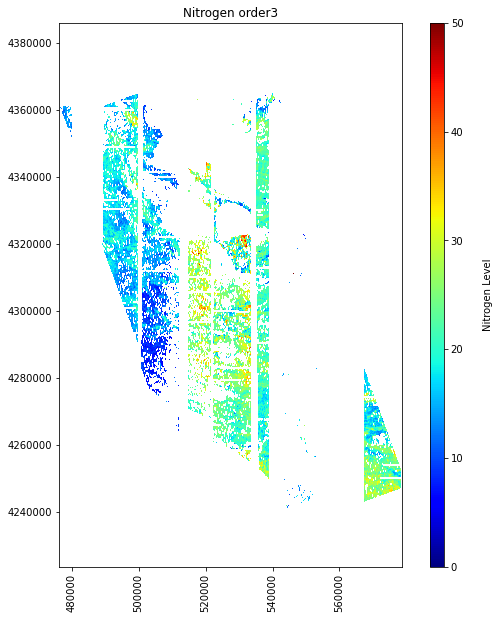

In [33]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(merged_nitrogen_mask[0,:,:],
           nitrogen_extent,
           (0,50),
           title='Nitrogen order3',
           cmap_title='Nitrogen Level',
           colormap='jet')


